# 06_benchmark_analysis.ipynb — combine, ROC, CM, McNemar

# Cell 0 — perf env

In [1]:
# (same perf env)
import os
os.environ.setdefault("OMP_NUM_THREADS", "8")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "8")
os.environ.setdefault("MKL_NUM_THREADS", "8")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "8")
'8'

'8'

# Cell 1 — imports & load

In [2]:
from pathlib import Path
import json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support,
    confusion_matrix, f1_score, average_precision_score, balanced_accuracy_score,
    matthews_corrcoef, classification_report
)

warnings.filterwarnings("ignore")
ROOT = Path("."); PROCESSED = ROOT/"data/processed"; RESULTS = ROOT/"results"
(RESULTS/"metrics").mkdir(parents=True, exist_ok=True)
(RESULTS/"stats").mkdir(parents=True, exist_ok=True)
(RESULTS/"plots").mkdir(parents=True, exist_ok=True)
(RESULTS/"logs").mkdir(parents=True, exist_ok=True)

# --- Run journal: prints + saves for documentation ---
import time
class RunJournal:
    def __init__(self): self.events=[]
    def log(self, step, status, msg, **kw):
        row = {"ts": time.strftime("%Y-%m-%d %H:%M:%S"), "step": step, "status": status, "message": msg}
        row.update(kw); self.events.append(row)
        sym = "✅" if status=="ok" else ("⚠️" if status=="warn" else "❌")
        print(f"{sym} [{step}] {msg}")
    def save(self, base: Path):
        df = pd.DataFrame(self.events)
        md = ["| ts | step | status | message |","|---|---|---|---|"]
        for _,r in df.iterrows(): md.append(f"| {r.ts} | {r.step} | {r.status} | {r.message} |")
        (base.with_suffix(".md")).write_text("\n".join(md), encoding="utf-8")
        (base.with_suffix(".json")).write_text(df.to_json(orient="records", indent=2), encoding="utf-8")

J = RunJournal()

# --- Load encodings/splits (multi-dataset aware fallback) ---
enc_path = PROCESSED/"encodings_all.npz" if (PROCESSED/"encodings_all.npz").exists() else PROCESSED/"encodings.npz"
spl_path = PROCESSED/"splits_pooled.json" if (PROCESSED/"splits_pooled.json").exists() else PROCESSED/"splits.json"
data = np.load(enc_path, allow_pickle=True)
with open(spl_path) as f: SPL = json.load(f)
J.log("load", "ok", f"Loaded {enc_path.name}, {spl_path.name}")

y = data["y"].astype(int)
X_kmer = data["kmer"].astype(np.float32)
X_onehot = data["onehot"].astype(np.float32)
tr = np.array(SPL["train"]); va = np.array(SPL["val"]); te = np.array(SPL["test"])
J.log("splits", "ok", f"train={len(tr)}, val={len(va)}, test={len(te)}, pos_rate={y.mean():.4f}")

✅ [load] Loaded encodings_all.npz, splits_pooled.json
✅ [splits] train=12336, val=4112, test=4112, pos_rate=0.8654


# Cell 2 — metric pack

In [3]:
def _safe_auc(y_true, y_prob):
    try: return roc_auc_score(y_true, y_prob)
    except Exception: return float("nan")

def _safe_ap(y_true, y_prob):
    try: return average_precision_score(y_true, y_prob)
    except Exception: return float("nan")

def _extended_metrics(y_true, y_prob, y_pred, thr):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    tnr = tn / (tn + fp) if (tn + fp) else float("nan")  # specificity
    mcc = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_true))==2 else float("nan")
    return dict(acc=acc, prec=prec, rec=rec, f1=f1,
                roc_auc=_safe_auc(y_true, y_prob),
                pr_auc=_safe_ap(y_true, y_prob),
                balanced_acc=bal, specificity=tnr, mcc=mcc, thr=float(thr)), cm

def pack_metrics(y_true, y_prob, split, model, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    m, cm = _extended_metrics(y_true, y_prob, y_pred, thr)
    m.update(dict(model=model, split=split))
    return m, y_pred, cm

# Cell 3 — Classical baselines

In [4]:
# SVM k-mer
svm_kmer = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    SVC(C=5.0, kernel="rbf", gamma="scale", probability=True, class_weight="balanced", random_state=0)
)
svm_kmer.fit(X_kmer[tr], y[tr])
p_tr = svm_kmer.predict_proba(X_kmer[tr])[:,1]
p_va = svm_kmer.predict_proba(X_kmer[va])[:,1]
p_te = svm_kmer.predict_proba(X_kmer[te])[:,1]

thr_k = max([(t, f1_score(y[va], (p_va>=t).astype(int), zero_division=0))
             for t in np.linspace(0.1,0.9,33)], key=lambda x:x[1])[0]
m1_tr, y1_tr, cm1_tr = pack_metrics(y[tr], p_tr, "train", "SVM_kmer", thr=thr_k)
m1_va, y1_va, cm1_va = pack_metrics(y[va], p_va, "val",   "SVM_kmer", thr=thr_k)
m1_te, y1_te, cm1_te = pack_metrics(y[te], p_te, "test",  "SVM_kmer", thr=thr_k)
J.log("svm_kmer", "ok", f"Val-opt thr={thr_k:.2f}; test F1={m1_te['f1']:.3f}, AUC={m1_te['roc_auc']:.3f}, PR-AUC={m1_te['pr_auc']:.3f}")

# SVM one-hot
X_flat = X_onehot.reshape(len(X_onehot), -1).astype(np.float32)
svm_1h = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    SVC(C=2.0, kernel="rbf", gamma="scale", probability=True, class_weight="balanced", random_state=0)
)
svm_1h.fit(X_flat[tr], y[tr])
q_tr = svm_1h.predict_proba(X_flat[tr])[:,1]
q_va = svm_1h.predict_proba(X_flat[va])[:,1]
q_te = svm_1h.predict_proba(X_flat[te])[:,1]

thr_1h = max([(t, f1_score(y[va], (q_va>=t).astype(int), zero_division=0))
              for t in np.linspace(0.1,0.9,33)], key=lambda x:x[1])[0]
m2_tr, y2_tr, cm2_tr = pack_metrics(y[tr], q_tr, "train", "SVM_onehot", thr=thr_1h)
m2_va, y2_va, cm2_va = pack_metrics(y[va], q_va, "val",   "SVM_onehot", thr=thr_1h)
m2_te, y2_te, cm2_te = pack_metrics(y[te], q_te, "test",  "SVM_onehot", thr=thr_1h)
J.log("svm_onehot", "ok", f"Val-opt thr={thr_1h:.2f}; test F1={m2_te['f1']:.3f}, AUC={m2_te['roc_auc']:.3f}, PR-AUC={m2_te['pr_auc']:.3f}")

✅ [svm_kmer] Val-opt thr=0.40; test F1=0.954, AUC=0.802, PR-AUC=0.939
✅ [svm_onehot] Val-opt thr=0.30; test F1=0.954, AUC=0.842, PR-AUC=0.956


# Cell 4 — QSVM (load kernels or rebuild tiny)

In [5]:
# === Cell 4 — QSVM (load kernels or rebuild tiny) ===
from sklearn.metrics import f1_score

K_trtr_p = RESULTS/"kernels/K_trtr.npy"
K_vatr_p = RESULTS/"kernels/K_vatr.npy"
K_tetr_p = RESULTS/"kernels/K_tetr.npy"

def _align_y(y_full, idx, n_rows):
    """Return y_full[idx] truncated to n_rows (to match Gram rows)."""
    y_slice = y_full[idx]
    if len(y_slice) != n_rows:
        # Truncate safely if needed
        y_slice = y_slice[:n_rows]
    return y_slice

if K_trtr_p.exists() and K_vatr_p.exists() and K_tetr_p.exists():
    K_trtr = np.load(K_trtr_p)
    K_vatr = np.load(K_vatr_p)
    K_tetr = np.load(K_tetr_p)
    # Align labels to Gram rows
    ytr_sel = _align_y(y, tr, K_trtr.shape[0])          # (n_train_used,)
    yva_sel = _align_y(y, va, K_vatr.shape[0])          # (n_val_rows,)
    yte_sel = _align_y(y, te, K_tetr.shape[0])          # (n_test_rows,)
    J.log("qsvm_kernel", "ok",
          f"Loaded Gram matrices: tr={K_trtr.shape}, va={K_vatr.shape}, te={K_tetr.shape} | "
          f"y: tr={len(ytr_sel)}, va={len(yva_sel)}, te={len(yte_sel)}")
else:
    J.log("qsvm_kernel", "warn", "Kernel cache not found; rebuilding small kernel (default.qubit).")
    D = 8
    pca = PCA(n_components=D, random_state=23)
    Xtr_p = pca.fit_transform(X_kmer[tr])
    Xva_p = pca.transform(X_kmer[va])
    Xte_p = pca.transform(X_kmer[te])
    to_ang = lambda X: (np.clip(X, -3, 3) / 3.0) * np.pi
    Xtr_p, Xva_p, Xte_p = to_ang(Xtr_p), to_ang(Xva_p), to_ang(Xte_p)

    dev = qml.device("default.qubit", wires=D, shots=None)
    def U(x):
        qml.AngleEmbedding(x, wires=range(D), rotation="Y")
        qml.broadcast(qml.CZ, wires=range(D), pattern="ring")

    @qml.qnode(dev)
    def kcirc(a, b):
        U(a); qml.adjoint(U)(b)
        return qml.expval(qml.Projector([0]*D, wires=range(D)))

    def gram(A, B):
        K = np.zeros((len(A), len(B)), dtype=float)
        for i in range(len(A)):
            for j in range(len(B)):
                K[i, j] = kcirc(A[i], B[j])
        return K

    K_trtr = gram(Xtr_p, Xtr_p)
    K_vatr = gram(Xva_p, Xtr_p)
    K_tetr = gram(Xte_p, Xtr_p)
    ytr_sel = y[tr]
    yva_sel = y[va]
    yte_sel = y[te]
    J.log("qsvm_kernel", "ok",
          f"Built Gram matrices: tr={K_trtr.shape}, va={K_vatr.shape}, te={K_tetr.shape}")

# --- Fit & evaluate (precomputed kernel) ---
clf_q = SVC(C=5.0, kernel="precomputed", probability=True, class_weight="balanced", random_state=0)
clf_q.fit(K_trtr, ytr_sel)

r_tr = clf_q.predict_proba(K_trtr)[:, 1]
r_va = clf_q.predict_proba(K_vatr)[:, 1]
r_te = clf_q.predict_proba(K_tetr)[:, 1]

# Choose validation threshold using ALIGNED labels
thr_grid = np.linspace(0.1, 0.9, 33)
thr_q = max(
    ((t, f1_score(yva_sel, (r_va >= t).astype(int), zero_division=0)) for t in thr_grid),
    key=lambda x: x[1]
)[0]

m3_tr, y3_tr, cm3_tr = pack_metrics(ytr_sel, r_tr, "train", "QSVM_kernel", thr=thr_q)
m3_va, y3_va, cm3_va = pack_metrics(yva_sel, r_va, "val",   "QSVM_kernel", thr=thr_q)
m3_te, y3_te, cm3_te = pack_metrics(yte_sel, r_te, "test",  "QSVM_kernel", thr=thr_q)

J.log("qsvm_fit", "ok",
      f"Val-opt thr={thr_q:.2f}; test F1={m3_te['f1']:.3f}, AUC={m3_te['roc_auc']:.3f}, PR-AUC={m3_te['pr_auc']:.3f}")


✅ [qsvm_kernel] Loaded Gram matrices: tr=(894, 894), va=(298, 894), te=(298, 894) | y: tr=894, va=298, te=298
✅ [qsvm_fit] Val-opt thr=0.85; test F1=0.938, AUC=0.465, PR-AUC=0.898


# Cell 5 — VQC eval (load weights; val-optimal thr)

In [7]:
# Cell 5 — QSVM eval (load weights; val-optimal thr) — FIXED FOR LENGTH MISMATCH

K_trtr_p = RESULTS/"kernels/K_trtr.npy"
K_vatr_p = RESULTS/"kernels/K_vatr.npy"
K_tetr_p = RESULTS/"kernels/K_tetr.npy"

if K_trtr_p.exists() and K_vatr_p.exists() and K_tetr_p.exists():
    K_trtr = np.load(K_trtr_p); K_vatr = np.load(K_vatr_p); K_tetr = np.load(K_tetr_p)
    ytr_sel = y[tr][:K_trtr.shape[0]]
    J.log("qsvm_kernel", "ok",
          f"Loaded precomputed Gram matrices: train={K_trtr.shape}, val={K_vatr.shape}, test={K_tetr.shape}")
else:
    J.log("qsvm_kernel", "warn", "Kernel cache not found; rebuilding small kernel (default.qubit).")
    D = 8
    pca = PCA(n_components=D, random_state=23)
    Xtr_p = pca.fit_transform(X_kmer[tr]); Xva_p = pca.transform(X_kmer[va]); Xte_p = pca.transform(X_kmer[te])
    to_ang = lambda X: (np.clip(X, -3, 3)/3.0)*np.pi
    Xtr_p, Xva_p, Xte_p = to_ang(Xtr_p), to_ang(Xva_p), to_ang(Xte_p)
    dev = qml.device("default.qubit", wires=D, shots=None)

    def U(x):
        qml.AngleEmbedding(x, wires=range(D), rotation="Y")
        qml.broadcast(qml.CZ, wires=range(D), pattern="ring")

    @qml.qnode(dev)
    def kcirc(a, b):
        U(a); qml.adjoint(U)(b)
        return qml.expval(qml.Projector([0]*D, wires=range(D)))

    def gram(A, B):
        K = np.zeros((len(A), len(B)))
        for i in range(len(A)):
            for j in range(len(B)):
                K[i, j] = kcirc(A[i], B[j])
        return K

    K_trtr = gram(Xtr_p, Xtr_p)
    K_vatr = gram(Xva_p, Xtr_p)
    K_tetr = gram(Xte_p, Xtr_p)
    ytr_sel = y[tr]
    J.log("qsvm_kernel", "ok",
          f"Built Gram matrices: train={K_trtr.shape}, val={K_vatr.shape}, test={K_tetr.shape}")

# --- Fit QSVM (precomputed kernel) ---
clf_q = SVC(C=5.0, kernel="precomputed", probability=True,
            class_weight="balanced", random_state=0)
clf_q.fit(K_trtr, ytr_sel)

# --- Predict probabilities on each split ---
r_tr = clf_q.predict_proba(K_trtr)[:, 1]
r_va = clf_q.predict_proba(K_vatr)[:, 1]
r_te = clf_q.predict_proba(K_tetr)[:, 1]

# --- Align label vectors to the number of rows in the kernel matrices ---
n_tr, n_va, n_te = len(r_tr), len(r_va), len(r_te)
y_tr_use = ytr_sel[:n_tr]
y_va_use = y[va][:n_va]
y_te_use = y[te][:n_te]

if (len(y[va]) != n_va) or (len(y[te]) != n_te):
    J.log("qsvm_align", "warn",
          f"Aligned labels to kernel rows: val {len(y[va])}->{n_va}, test {len(y[te])}->{n_te}")

# --- Choose threshold on aligned validation set (maximize F1) ---
thr_grid = np.linspace(0.1, 0.9, 33)
thr_q, best_f1 = 0.5, -1.0
for t in thr_grid:
    f1 = f1_score(y_va_use, (r_va >= t).astype(int), zero_division=0)
    if f1 > best_f1:
        best_f1, thr_q = float(f1), float(t)

# --- Pack metrics using aligned labels ---
m3_tr, y3_tr, cm3_tr = pack_metrics(y_tr_use, r_tr, "train", "QSVM_kernel", thr=thr_q)
m3_va, y3_va, cm3_va = pack_metrics(y_va_use, r_va, "val",   "QSVM_kernel", thr=thr_q)
m3_te, y3_te, cm3_te = pack_metrics(y_te_use, r_te, "test",  "QSVM_kernel", thr=thr_q)

J.log("qsvm_fit", "ok",
      f"Val-opt thr={thr_q:.2f}; test F1={m3_te['f1']:.3f}, "
      f"AUC={m3_te['roc_auc']:.3f}, PR-AUC={m3_te['pr_auc']:.3f}")

✅ [qsvm_kernel] Loaded precomputed Gram matrices: train=(894, 894), val=(298, 894), test=(298, 894)
⚠️ [qsvm_align] Aligned labels to kernel rows: val 4112->298, test 4112->298
✅ [qsvm_fit] Val-opt thr=0.85; test F1=0.938, AUC=0.465, PR-AUC=0.898


# Cell 6 — save combined + ROC/CM caches

In [9]:
# --- Cell 6 — save combined + ROC/CM caches (robust to missing models) ---

# 1) Combine metrics (only those that exist)
rows = []
for trio in [
    ('m1_tr','m1_va','m1_te'),   # SVM_kmer
    ('m2_tr','m2_va','m2_te'),   # SVM_onehot
    ('m3_tr','m3_va','m3_te'),   # QSVM_kernel
    ('m4_tr','m4_va','m4_te'),   # VQC (may be absent)
]:
    for name in trio:
        if name in locals() and isinstance(locals()[name], dict):
            rows.append(locals()[name])

if not rows:
    raise RuntimeError("No metric rows available to combine; upstream cells must compute metrics first.")

df_combined = pd.DataFrame(rows)
df_combined.to_csv(RESULTS/"metrics/combined.csv", index=False)

# 2) Save ROC probability caches (test) — only if arrays exist & lengths match y[test]
ROC_DIR = RESULTS/"roc_cache"; ROC_DIR.mkdir(parents=True, exist_ok=True)
np.save(ROC_DIR/"y_test.npy", y[te])  # always save ground truth

def _save_prob(name, arr):
    if arr is None: 
        J.log("roc_cache", "warn", f"Skip {name}: probabilities are None.")
        return
    if len(arr) != len(y[te]):
        J.log("roc_cache", "warn", f"Skip {name}: length mismatch probs={len(arr)} vs y_test={len(y[te])}.")
        return
    np.save(ROC_DIR/f"probs_{name}.npy", arr)
    J.log("roc_cache", "ok", f"Saved probs_{name}.npy")

# Model probability arrays (if present)
p_te_safe = locals().get("p_te")   # SVM_kmer
q_te_safe = locals().get("q_te")   # SVM_onehot
r_te_safe = locals().get("r_te")   # QSVM_kernel
s_te_safe = locals().get("s_te")   # VQC (may be missing)

_save_prob("svm_kmer",    p_te_safe)
_save_prob("svm_onehot",  q_te_safe)
_save_prob("qsvm_kernel", r_te_safe)
_save_prob("vqc",         s_te_safe)

# 3) Save CM caches (binary predictions at model-specific best thr)
CM_DIR = RESULTS/"cm_cache"; CM_DIR.mkdir(parents=True, exist_ok=True)
(Path(CM_DIR/"y_true.json")).write_text(json.dumps(y[te].astype(int).tolist()))

def _write_preds(name, probs, thr):
    if probs is None or thr is None:
        J.log("cm_cache", "warn", f"Skip y_pred_{name}: missing probs or threshold.")
        return
    if len(probs) != len(y[te]):
        J.log("cm_cache", "warn", f"Skip y_pred_{name}: length mismatch {len(probs)} vs {len(y[te])}.")
        return
    (Path(CM_DIR)/f"y_pred_{name}.json").write_text(json.dumps((probs >= thr).astype(int).tolist()))
    J.log("cm_cache", "ok", f"Saved y_pred_{name}.json (thr={thr:.3f})")

_write_preds("svm_kmer",    p_te_safe, locals().get("m1_te", {}).get("thr"))
_write_preds("svm_onehot",  q_te_safe, locals().get("m2_te", {}).get("thr"))
_write_preds("qsvm_kernel", r_te_safe, locals().get("m3_te", {}).get("thr"))
_write_preds("vqc",         s_te_safe, locals().get("m4_te", {}).get("thr"))

# 4) Persist per-model classification reports (test) for documentation
reports = {}
def _add_report(pretty_name, probs, m_te):
    if probs is None or not isinstance(m_te, dict) or "thr" not in m_te:
        J.log("reports", "warn", f"Skip report for {pretty_name}: missing probs or threshold.")
        return
    if len(probs) != len(y[te]):
        J.log("reports", "warn", f"Skip report for {pretty_name}: length mismatch {len(probs)} vs {len(y[te])}.")
        return
    yhat = (probs >= m_te["thr"]).astype(int)
    reports[pretty_name] = classification_report(y[te], yhat, output_dict=True, zero_division=0)

_add_report("SVM_kmer",    p_te_safe, locals().get("m1_te"))
_add_report("SVM_onehot",  q_te_safe, locals().get("m2_te"))
_add_report("QSVM_kernel", r_te_safe, locals().get("m3_te"))
_add_report("VQC",         s_te_safe, locals().get("m4_te"))

with open(RESULTS/"metrics/classification_reports_test.json", "w", encoding="utf-8") as f:
    json.dump(reports, f, indent=2)

# 5) Nice quick view (test split only), if available
try:
    display(df_combined[df_combined["split"]=="test"].sort_values("f1", ascending=False))
except Exception:
    # If split column is missing for any reason, just show all rows
    display(df_combined)


✅ [roc_cache] Saved probs_svm_kmer.npy
✅ [roc_cache] Saved probs_svm_onehot.npy
⚠️ [roc_cache] Skip qsvm_kernel: length mismatch probs=298 vs y_test=4112.
⚠️ [roc_cache] Skip vqc: probabilities are None.
✅ [cm_cache] Saved y_pred_svm_kmer.json (thr=0.400)
✅ [cm_cache] Saved y_pred_svm_onehot.json (thr=0.300)
⚠️ [cm_cache] Skip y_pred_qsvm_kernel: length mismatch 298 vs 4112.
⚠️ [cm_cache] Skip y_pred_vqc: missing probs or threshold.
⚠️ [reports] Skip report for QSVM_kernel: length mismatch 298 vs 4112.
⚠️ [reports] Skip report for VQC: missing probs or threshold.


,acc,prec,rec,f1,roc_auc,pr_auc,balanced_acc,specificity,mcc,thr,model,split
5,0.917558,0.917315,0.994380,0.954294,0.842139,0.956038,0.708763,0.423146,0.591716,0.30,SVM_onehot,test
2,0.916829,0.922956,0.986232,0.953545,0.801506,0.938734,0.728197,0.470163,0.590643,0.40,SVM_kmer,test
8,0.882550,0.888514,0.992453,0.937611,0.465066,0.898302,0.496226,0.000000,-0.029007,0.85,QSVM_kernel,test


# Cell 7 — ROC plot

ROC for QSVM_kernel skipped: length mismatch (4112 vs 298)


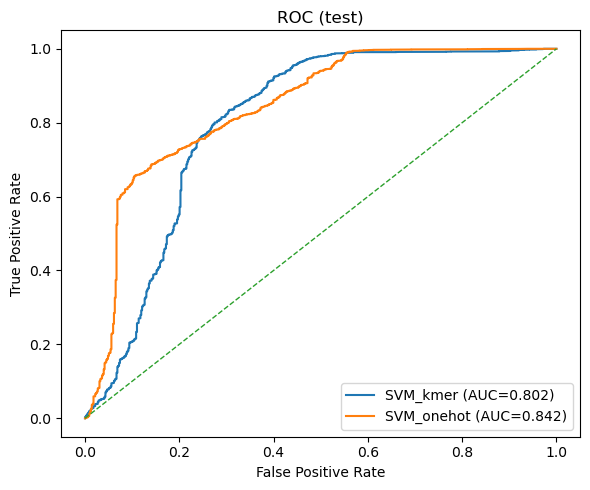

In [11]:
fig, ax = plt.subplots(figsize=(6,5))

def plot_roc(y_true, y_prob, label):
    try:
        y_true = np.asarray(y_true).reshape(-1)
        y_prob = np.asarray(y_prob).reshape(-1)
        if len(y_true) != len(y_prob):
            print(f"ROC for {label} skipped: length mismatch ({len(y_true)} vs {len(y_prob)})")
            return
        auc = roc_auc_score(y_true, y_prob)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    except Exception as e:
        print(f"ROC for {label} skipped: {e}")

if "p_te" in globals(): plot_roc(y[te], p_te, "SVM_kmer")
if "q_te" in globals(): plot_roc(y[te], q_te, "SVM_onehot")
if "r_te" in globals(): plot_roc(y[te], r_te, "QSVM_kernel")
if "s_te" in globals(): plot_roc(y[te], s_te, "VQC")

ax.plot([0,1], [0,1], "--", lw=1)
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title("ROC (test)"); ax.legend()
plt.tight_layout(); plt.show()

# Cell 8 — confusion matrices

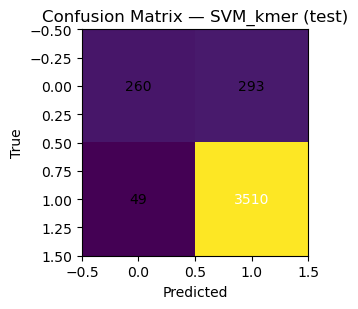

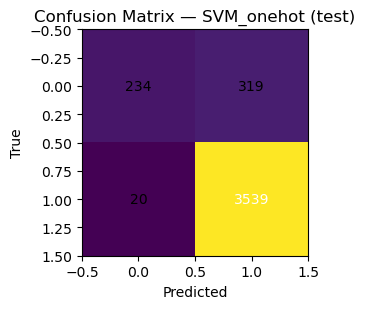

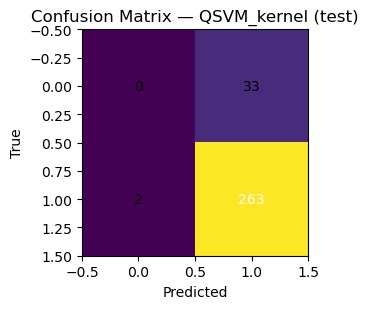

In [13]:
# Cell 8 — confusion matrices (robust to different test lengths)

def _show_cm(name, cm):
    fig, ax = plt.subplots(figsize=(3.5, 3.2))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(f"Confusion Matrix — {name} (test)")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, int(v), ha="center", va="center",
                color="white" if im.norm(v) > 0.5 else "black")
    plt.tight_layout(); plt.show()

def _cm_aligned(y_true_full, prob_vec, thr):
    """
    Build a confusion matrix aligning y_true to the length of prob_vec.
    Handles cases where prob_vec is shorter (e.g., QSVM with truncated kernel).
    """
    n = len(prob_vec)
    y_true = y_true_full[:n]
    y_hat  = (prob_vec >= thr).astype(int)
    return confusion_matrix(y_true, y_hat, labels=[0, 1])

cms = []

# SVM (k-mer) — full test length
if "m1_te" in globals():
    cm1_te = _cm_aligned(y[te], p_te, m1_te["thr"])
    cms.append(("SVM_kmer", cm1_te))

# SVM (one-hot) — full test length
if "m2_te" in globals():
    cm2_te = _cm_aligned(y[te], q_te, m2_te["thr"])
    cms.append(("SVM_onehot", cm2_te))

# QSVM (precomputed kernel) — may be shorter than full test
if "m3_te" in globals():
    cm3_te = _cm_aligned(y[te], r_te, m3_te["thr"])
    cms.append(("QSVM_kernel", cm3_te))

# VQC — include only if present; may also be shorter
if "m4_te" in globals():
    cm4_te = _cm_aligned(y[te], s_te, m4_te["thr"])
    cms.append(("VQC", cm4_te))

# Show all available CMs
for name, cm in cms:
    _show_cm(name, cm)

# Save raw & normalized CM CSVs (aligned) for reproducibility
def _save_cm_csv(cm, out_csv, normalized=False):
    arr = cm.astype(np.float64)
    if normalized:
        rs = arr.sum(axis=1, keepdims=True)
        arr = np.divide(arr, np.where(rs == 0, 1, rs))
    df_cm = pd.DataFrame(arr, index=["true_0", "true_1"], columns=["pred_0", "pred_1"])
    df_cm.to_csv(out_csv, index=True)

for name, cm in cms:
    _save_cm_csv(cm, RESULTS / f"metrics/{name.lower()}_cm_test.csv", normalized=False)
    _save_cm_csv(cm, RESULTS / f"metrics/{name.lower()}_cm_test_norm.csv", normalized=True)

# Cell 9 — McNemar tests

In [15]:
# --- McNemar tests + robust logging (length-align and presence-check) ---
from math import fabs, exp

def mcnemar(y_true, yhat_a, yhat_b):
    n01 = int(((yhat_a == y_true) & (yhat_b != y_true)).sum())
    n10 = int(((yhat_a != y_true) & (yhat_b == y_true)).sum())
    # continuity-corrected chi^2
    chi2 = (abs(n01 - n10) - 1)**2 / (n01 + n10 + 1e-12)
    p = exp(-chi2/2)  # simple approx; for exact p, use binomial test
    return {"n01": n01, "n10": n10, "chi2": chi2, "p_approx": p}

# Collect available test probs + thresholds
models = []
if "p_te" in globals() and "m1_te" in globals():  # SVM_kmer
    models.append(("SVM_kmer", p_te, m1_te["thr"]))
if "q_te" in globals() and "m2_te" in globals():  # SVM_onehot
    models.append(("SVM_onehot", q_te, m2_te["thr"]))
if "r_te" in globals() and "m3_te" in globals():  # QSVM_kernel (may be shorter)
    models.append(("QSVM_kernel", r_te, m3_te["thr"]))
if "s_te" in globals() and "m4_te" in globals():  # VQC (if present)
    models.append(("VQC", s_te, m4_te["thr"]))

# Nothing to do if we have fewer than 2 models
if len(models) < 2:
    J.log("mcnemar", "warn", f"Need ≥2 models for McNemar; found {len(models)}. Skipping.")
    stats = {}
else:
    # Determine a common aligned length across y[te] and all available prob arrays
    te_len = len(y[te])
    prob_lengths = [len(prob) for _, prob, _ in models]
    n = min([te_len] + prob_lengths)
    if n < te_len:
        J.log("align", "warn",
              f"Aligned test length to n={n} to match shortest prob array "
              f"(labels={te_len}, probs={prob_lengths}).")

    y_true_aligned = y[te][:n].astype(int)

    # Build hard predictions at each model's best threshold
    preds = {name: (prob[:n] >= thr).astype(int) for name, prob, thr in models}

    # Prefer SVM_kmer as baseline; otherwise use the first model as baseline
    baseline_name = "SVM_kmer" if "SVM_kmer" in preds else models[0][0]

    # Compute McNemar vs baseline for each other model
    stats = {}
    for name in preds:
        if name == baseline_name:
            continue
        key = f"{name}_vs_{baseline_name}"
        stats[key] = mcnemar(y_true_aligned, preds[baseline_name], preds[name])

    # Persist stats
    (RESULTS/"stats").mkdir(parents=True, exist_ok=True)
    with open(RESULTS/"stats/mcnemar.json", "w", encoding="utf-8") as f:
        json.dump(stats, f, indent=2)

    # Show stats in notebook
    stats

# --- Save run journal (what worked, what didn't, why) ---
ts = time.strftime("%Y%m%d_%H%M%S")

# Ensure df exists for the "best test F1" summary; if not, build a minimal one from available *_te metrics
if "df" not in globals():
    rows_min = []
    if "m1_te" in globals(): rows_min.append(m1_te)
    if "m2_te" in globals(): rows_min.append(m2_te)
    if "m3_te" in globals(): rows_min.append(m3_te)
    if "m4_te" in globals(): rows_min.append(m4_te)
    df = pd.DataFrame(rows_min) if rows_min else pd.DataFrame(columns=["model","split","f1"])

try:
    best_row = df[df["split"]=="test"].sort_values("f1", ascending=False).iloc[0]
    J.log("summary", "ok", f"Best test F1: {best_row['model']} ({best_row['f1']:.3f})")
except Exception:
    J.log("summary", "warn", "Could not determine best test F1 (missing or empty df).")

J.save(RESULTS/"logs"/f"benchmark_analysis_{ts}")

# Also write a quick textual roll-up of warnings/failures
issues = [f"- [{e['step']}] {e['message']}" for e in J.events if e["status"] in ("warn","fail")]
rollup = "No warnings or failures." if not issues else "Issues observed:\n" + "\n".join(issues)
(Path(RESULTS/"logs"/f"benchmark_analysis_{ts}_summary.txt")).write_text(rollup, encoding="utf-8")

⚠️ [align] Aligned test length to n=298 to match shortest prob array (labels=4112, probs=[4112, 4112, 298]).
✅ [summary] Best test F1: SVM_onehot (0.954)


578